In [1]:
# ============================================================
# BLOCK 0A: Choose GPU + reduce fragmentation
# IMPORTANT: restart kernel after running this cell.
# ============================================================
import os

# Pick a free GPU: "1" or "2" (your nvidia-smi shows these are empty)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Helps fragmentation in shared environments
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [4]:
# ============================================================
# BLOCK 0B: Imports + Paths + Device
# ============================================================

from __future__ import annotations
import os, json, time, math, random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import librosa
import matplotlib.pyplot as plt

# -----------------------------
# Your paths (as you stated)
# -----------------------------
WORK_DIR = Path("/home/jovyan/work")
SMALL_ROOT = WORK_DIR / "musicnet_small/musicnet_small"

TRAIN_AUDIO_DIR = SMALL_ROOT / "train_data"
TRAIN_LABEL_DIR = SMALL_ROOT / "train_labels"
TEST_AUDIO_DIR  = SMALL_ROOT / "test_data"
TEST_LABEL_DIR  = SMALL_ROOT / "test_labels"
META_PATH = WORK_DIR / "musicnet_metadata.csv"

# Outputs
OUT_ROOT = Path("/home/jovyan/shared/musicnet_event_notebook")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

FEAT_DIR = OUT_ROOT / "mel_event_npz"
FEAT_DIR.mkdir(parents=True, exist_ok=True)

CKPT_DIR = OUT_ROOT / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

FIG_DIR = OUT_ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = OUT_ROOT / "manifest.csv"
SPLITS_PATH   = OUT_ROOT / "splits.json"
VOCAB_PATH    = OUT_ROOT / "vocab_info.json"

# -----------------------------
# Device
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
if DEVICE == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

# Stable loaders on JupyterHub
NUM_WORKERS = 0
PIN_MEMORY = (DEVICE == "cuda")

# Repro
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Sanity
assert TRAIN_AUDIO_DIR.exists() and TRAIN_LABEL_DIR.exists()
assert TEST_AUDIO_DIR.exists() and TEST_LABEL_DIR.exists()
assert META_PATH.exists()

print("OUT_ROOT:", OUT_ROOT)

DEVICE: cuda
GPU: Tesla V100-PCIE-16GB
OUT_ROOT: /home/jovyan/shared/musicnet_event_notebook


In [5]:
def list_wavs(d: Path): return sorted(d.glob("*.wav"))
train_wavs = list_wavs(TRAIN_AUDIO_DIR)
test_wavs  = list_wavs(TEST_AUDIO_DIR)

TRAIN_POOL_IDS = sorted([int(p.stem) for p in train_wavs])
TEST_IDS       = sorted([int(p.stem) for p in test_wavs])

meta = pd.read_csv(META_PATH)
meta["id"] = meta["id"].astype(int)

N_VAL = 8
assert len(TRAIN_POOL_IDS) >= 40 and len(TEST_IDS) == 10

def work_key(row: pd.Series) -> Tuple[str,str]:
    return (str(row.get("composer","UNKNOWN")).strip(), str(row.get("composition","UNKNOWN")).strip())

def make_val_split(meta_df, train_pool_ids, n_val=8, seed=42):
    rng = random.Random(seed)
    df = meta_df[meta_df["id"].isin(train_pool_ids)].copy()
    df["composer"] = df["composer"].fillna("UNKNOWN_COMPOSER")
    df["composition"] = df["composition"].fillna(df["id"].apply(lambda x: f"id_{x}"))
    df["work_key"] = df.apply(work_key, axis=1)
    groups = df.groupby("work_key")["id"].apply(list).tolist()
    rng.shuffle(groups)
    val_ids = []
    for g in groups:
        if len(val_ids) + len(g) <= n_val:
            val_ids.extend(g)
        if len(val_ids) == n_val:
            break
    if len(val_ids) < n_val:
        remaining = [tid for tid in train_pool_ids if tid not in val_ids]
        rng.shuffle(remaining)
        val_ids.extend(remaining[:(n_val - len(val_ids))])
    val_ids = sorted(set(val_ids))
    train_ids = sorted([tid for tid in train_pool_ids if tid not in val_ids])
    return train_ids, val_ids

train_ids, val_ids = make_val_split(meta, TRAIN_POOL_IDS, n_val=N_VAL, seed=42)
splits = {"train_ids": train_ids, "val_ids": val_ids, "test_ids": TEST_IDS}
with open(SPLITS_PATH, "w") as f:
    json.dump(splits, f, indent=2)

print("Saved:", SPLITS_PATH)
print("Train/Val/Test:", len(train_ids), len(val_ids), len(TEST_IDS))
print("Val IDs:", val_ids)


Saved: /home/jovyan/shared/musicnet_event_notebook/splits.json
Train/Val/Test: 32 8 10
Val IDs: [2200, 2201, 2213, 2214, 2215, 2224, 2591, 2620]


In [6]:
def read_label_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = {"start_time","end_time","instrument","note"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{path} missing columns: {missing}")
    df = df.copy()
    df["start_time"] = df["start_time"].astype(int)
    df["end_time"]   = df["end_time"].astype(int)
    df["instrument"] = df["instrument"].astype(int)
    df["note"]       = df["note"].astype(int)
    return df

MIN_NOTE = 21
MAX_NOTE = 108
N_PITCH  = MAX_NOTE - MIN_NOTE + 1  # 88

def note_to_pitch_id(note: int) -> int:
    if note < MIN_NOTE or note > MAX_NOTE:
        return -1
    return note - MIN_NOTE


In [7]:
MAX_SHIFT = 100

TIME_SHIFT_BASE = 0
NOTE_ON_BASE    = TIME_SHIFT_BASE + MAX_SHIFT
NOTE_OFF_BASE   = NOTE_ON_BASE + N_PITCH
EVENT_VOCAB     = NOTE_OFF_BASE + N_PITCH

PAD_ID = EVENT_VOCAB
SOS_ID = EVENT_VOCAB + 1
EOS_ID = EVENT_VOCAB + 2
CTC_BLANK_ID = EVENT_VOCAB + 3
TOTAL_VOCAB = EVENT_VOCAB + 4

def tok_time_shift(k: int) -> int: return TIME_SHIFT_BASE + (k - 1)
def tok_note_on(p: int) -> int: return NOTE_ON_BASE + p
def tok_note_off(p: int) -> int: return NOTE_OFF_BASE + p

with open(VOCAB_PATH, "w") as f:
    json.dump(dict(MAX_SHIFT=MAX_SHIFT, N_PITCH=N_PITCH, EVENT_VOCAB=EVENT_VOCAB,
                   PAD_ID=PAD_ID, SOS_ID=SOS_ID, EOS_ID=EOS_ID, CTC_BLANK_ID=CTC_BLANK_ID,
                   TOTAL_VOCAB=TOTAL_VOCAB,
                   TIME_SHIFT_BASE=TIME_SHIFT_BASE, NOTE_ON_BASE=NOTE_ON_BASE, NOTE_OFF_BASE=NOTE_OFF_BASE),
              f, indent=2)

print("Vocab saved:", VOCAB_PATH, "| TOTAL_VOCAB:", TOTAL_VOCAB)


Vocab saved: /home/jovyan/shared/musicnet_event_notebook/vocab_info.json | TOTAL_VOCAB: 280


In [8]:
@dataclass
class PreprocCfg:
    sr: int = 44100
    n_fft: int = 2048
    hop_length: int = 512
    n_mels: int = 128
    fmin: float = 30.0
    fmax: float = 8000.0
    seg_seconds: float = 10.0
    hop_seconds: float = 5.0
    log_eps: float = 1e-6
    normalize: bool = True

CFG = PreprocCfg()
print("CFG:", CFG)

def compute_logmel(y: np.ndarray, cfg: PreprocCfg) -> np.ndarray:
    S = librosa.feature.melspectrogram(
        y=y, sr=cfg.sr, n_fft=cfg.n_fft, hop_length=cfg.hop_length,
        n_mels=cfg.n_mels, fmin=cfg.fmin, fmax=cfg.fmax,
        power=2.0, center=False
    )
    X = np.log(S.astype(np.float32) + cfg.log_eps)
    if cfg.normalize:
        X = (X - X.mean()) / (X.std() + 1e-8)
    return X.astype(np.float32)  # (M,T)

def events_for_segment(df: pd.DataFrame, seg_start_samp: int, seg_end_samp: int, cfg: PreprocCfg) -> List[int]:
    d = df[(df["start_time"] < seg_end_samp) & (df["end_time"] > seg_start_samp)].copy()
    if len(d) == 0:
        return []

    def samp_to_frame(s): return int((s - seg_start_samp) // cfg.hop_length)

    on_map  = defaultdict(list)
    off_map = defaultdict(list)

    for _, r in d.iterrows():
        p = note_to_pitch_id(int(r["note"]))
        if p < 0: 
            continue
        on_f  = max(0, samp_to_frame(int(r["start_time"])))
        off_f = max(0, samp_to_frame(int(r["end_time"])))
        on_map[on_f].append(p)
        off_map[off_f].append(p)

    frames = sorted(set(on_map.keys()) | set(off_map.keys()))
    if not frames:
        return []

    toks = []
    cur = 0
    for f in frames:
        dt = f - cur
        while dt > 0:
            k = min(MAX_SHIFT, dt)
            toks.append(tok_time_shift(k))
            dt -= k
        cur = f

        for p in sorted(off_map.get(f, [])):
            toks.append(tok_note_off(p))
        for p in sorted(on_map.get(f, [])):
            toks.append(tok_note_on(p))

    toks.append(EOS_ID)
    return toks


CFG: PreprocCfg(sr=44100, n_fft=2048, hop_length=512, n_mels=128, fmin=30.0, fmax=8000.0, seg_seconds=10.0, hop_seconds=5.0, log_eps=1e-06, normalize=True)


In [9]:
FORCE_REBUILD = False  # set True if you changed vocab/tokenizer and must rebuild

seg_len_samp = int(CFG.seg_seconds * CFG.sr)
hop_len_samp = int(CFG.hop_seconds * CFG.sr)

def build_index_df():
    rows = []
    for w in sorted(TRAIN_AUDIO_DIR.glob("*.wav")):
        tid = int(w.stem)
        rows.append({"id": tid, "audio": str(w), "label": str(TRAIN_LABEL_DIR / f"{tid}.csv")})
    for w in sorted(TEST_AUDIO_DIR.glob("*.wav")):
        tid = int(w.stem)
        rows.append({"id": tid, "audio": str(w), "label": str(TEST_LABEL_DIR / f"{tid}.csv")})
    return pd.DataFrame(rows)

index_df = build_index_df()
with open(SPLITS_PATH, "r") as f:
    splits = json.load(f)

id_to_split = {int(t): "train" for t in splits["train_ids"]}
id_to_split.update({int(t): "val" for t in splits["val_ids"]})
id_to_split.update({int(t): "test" for t in splits["test_ids"]})

if FORCE_REBUILD:
    print("Rebuilding features: wiping FEAT_DIR ...")
    for p in FEAT_DIR.glob("*.npz"):
        p.unlink(missing_ok=True)

if MANIFEST_PATH.exists() and not FORCE_REBUILD:
    manifest = pd.read_csv(MANIFEST_PATH)
    print("Loaded manifest:", MANIFEST_PATH)
else:
    rows = []
    print("Precomputing NPZ ...", flush=True)
    for _, r in index_df[index_df["id"].isin(id_to_split.keys())].iterrows():
        tid = int(r["id"])
        split = id_to_split[tid]
        wav_path = Path(r["audio"])
        lab_path = Path(r["label"])

        y_audio, _ = librosa.load(wav_path, sr=CFG.sr, mono=True)
        labs = read_label_csv(lab_path)
        total_samp = len(y_audio)
        seg_i = 0

        for seg_start in range(0, max(1, total_samp - seg_len_samp + 1), hop_len_samp):
            seg_end = seg_start + seg_len_samp
            if seg_end > total_samp:
                break

            X_mel = compute_logmel(y_audio[seg_start:seg_end], CFG)  # (M,T)
            X = X_mel.T  # (T,M)

            y_tok = events_for_segment(labs, seg_start, seg_end, CFG)
            if len(y_tok) == 0:
                continue

            npz_path = FEAT_DIR / f"{split}_id{tid}_seg{seg_i:05d}.npz"
            meta_out = dict(track_id=tid, split=split,
                            seg_start_samp=int(seg_start), seg_end_samp=int(seg_end),
                            hop_length=CFG.hop_length, sr=CFG.sr, n_mels=CFG.n_mels)

            np.savez_compressed(npz_path, X=X.astype(np.float16), y=np.asarray(y_tok, np.int32), meta=json.dumps(meta_out))

            rows.append(dict(split=split, track_id=tid, seg_idx=seg_i,
                             npz_path=str(npz_path), n_frames=int(X.shape[0]), n_tokens=int(len(y_tok))))
            seg_i += 1

    manifest = pd.DataFrame(rows)
    manifest.to_csv(MANIFEST_PATH, index=False)
    print("Saved manifest:", MANIFEST_PATH)

# Clean manifest (remove missing)
exists_mask = manifest["npz_path"].apply(lambda p: os.path.exists(p))
manifest = manifest.loc[exists_mask].reset_index(drop=True)
manifest.to_csv(MANIFEST_PATH, index=False)

print(manifest["split"].value_counts())
print("train token p90/p95:",
      manifest[manifest["split"]=="train"]["n_tokens"].quantile(0.9),
      manifest[manifest["split"]=="train"]["n_tokens"].quantile(0.95))


Loaded manifest: /home/jovyan/shared/musicnet_event_notebook/manifest.csv
split
train    693
test     280
val      194
Name: count, dtype: int64
train token p90/p95: 524.6000000000001 599.0


In [10]:
manifest = pd.read_csv(MANIFEST_PATH)
train_df = manifest[manifest["split"]=="train"].reset_index(drop=True)
val_df   = manifest[manifest["split"]=="val"].reset_index(drop=True)
test_df  = manifest[manifest["split"]=="test"].reset_index(drop=True)

MAX_TOKENS_TRAIN = 500
train_df = train_df[train_df["n_tokens"] <= MAX_TOKENS_TRAIN].reset_index(drop=True)

print("Segments train/val/test:", len(train_df), len(val_df), len(test_df))

class SegmentDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        z = np.load(row["npz_path"], allow_pickle=False)
        X = torch.from_numpy(z["X"].astype(np.float32))  # (T,M)
        y = torch.from_numpy(z["y"].astype(np.int64))    # (L,)
        meta = json.loads(z["meta"].item())
        return {"X": X, "x_len": X.shape[0], "y": y, "y_len": y.shape[0], "meta": meta}

def collate(batch):
    B = len(batch)
    Tm = max(b["x_len"] for b in batch)
    Lm = max(b["y_len"] for b in batch)
    M  = batch[0]["X"].shape[1]
    X_pad = torch.zeros((B,Tm,M), dtype=torch.float32)
    x_lens = torch.tensor([b["x_len"] for b in batch], dtype=torch.long)
    y_pad = torch.full((B,Lm), PAD_ID, dtype=torch.long)
    y_lens = torch.tensor([b["y_len"] for b in batch], dtype=torch.long)
    metas=[]
    for i,b in enumerate(batch):
        X_pad[i,:b["x_len"]] = b["X"]
        y_pad[i,:b["y_len"]] = b["y"]
        metas.append(b["meta"])
    return {"X": X_pad, "x_lens": x_lens, "y": y_pad, "y_lens": y_lens, "meta": metas}

BATCH = 8 if DEVICE=="cuda" else 4
train_loader = DataLoader(SegmentDataset(train_df), batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=PIN_MEMORY, collate_fn=collate)
val_loader   = DataLoader(SegmentDataset(val_df),   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY, collate_fn=collate)
test_loader  = DataLoader(SegmentDataset(test_df),  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY, collate_fn=collate)

b = next(iter(train_loader))
print("Batch X:", b["X"].shape, "Batch y:", b["y"].shape)


Segments train/val/test: 614 194 280
Batch X: torch.Size([8, 858, 128]) Batch y: torch.Size([8, 449])


In [11]:
class CNNBiLSTMEncoder(nn.Module):
    def __init__(self, n_mels: int, cnn_ch=(32,64,128), lstm_hidden=256, lstm_layers=2, drop=0.2):
        super().__init__()
        c1,c2,c3 = cnn_ch
        self.cnn = nn.Sequential(
            nn.Conv2d(1,c1,3,padding=1), nn.BatchNorm2d(c1), nn.ReLU(), nn.MaxPool2d((1,2)),
            nn.Conv2d(c1,c2,3,padding=1), nn.BatchNorm2d(c2), nn.ReLU(), nn.MaxPool2d((1,2)),
            nn.Conv2d(c2,c3,3,padding=1), nn.BatchNorm2d(c3), nn.ReLU(), nn.MaxPool2d((1,2)),
        )
        mel_after = n_mels // 8
        self.proj_in = c3 * mel_after
        self.lstm = nn.LSTM(self.proj_in, lstm_hidden, num_layers=lstm_layers,
                            batch_first=True, bidirectional=True,
                            dropout=drop if lstm_layers>1 else 0.0)

    def forward(self, X, x_lens):
        B,T,M = X.shape
        x = X.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0,2,1,3).contiguous()
        x = x.view(B, x.size(1), -1)
        packed = nn.utils.rnn.pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        enc,_ = self.lstm(packed)
        enc,_ = nn.utils.rnn.pad_packed_sequence(enc, batch_first=True)
        return enc, x_lens


In [12]:
def edit_distance(a: List[int], b: List[int]) -> int:
    n,m=len(a),len(b)
    dp=list(range(m+1))
    for i in range(1,n+1):
        prev=dp[0]; dp[0]=i
        for j in range(1,m+1):
            cur=dp[j]
            cost=0 if a[i-1]==b[j-1] else 1
            dp[j]=min(dp[j]+1, dp[j-1]+1, prev+cost)
            prev=cur
    return dp[m]


In [13]:
# ============================================================
# BLOCK 10 (FAST TRAIN): Seq2Seq (Attention-RNN) + Scheduled Sampling
# Prints ONE line per epoch quickly (train + FAST val subset)
#
# IMPORTANT: This block intentionally does NOT do full-val decoding per epoch.
# Full/slow decode sweep is in Block 10b.
#
# REQUIRES already defined earlier:
# - DEVICE, CFG, N_PITCH
# - vocab constants: TIME_SHIFT_BASE, NOTE_ON_BASE, NOTE_OFF_BASE, EVENT_VOCAB,
#   PAD_ID, SOS_ID, EOS_ID, CTC_BLANK_ID, TOTAL_VOCAB
# - CNNBiLSTMEncoder class
# - train_loader, val_loader
# - edit_distance function
# ============================================================

import time
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# CLASS WEIGHTS (fix distribution)
# -----------------------------
CLASS_W = torch.ones(TOTAL_VOCAB, dtype=torch.float32, device=DEVICE)
CLASS_W[TIME_SHIFT_BASE:NOTE_ON_BASE] = 4.0
CLASS_W[NOTE_ON_BASE:NOTE_OFF_BASE]   = 1.3
CLASS_W[NOTE_OFF_BASE:EVENT_VOCAB]    = 1.2
CLASS_W[EOS_ID] = 3.0
CLASS_W[PAD_ID] = 0.0
CLASS_W[SOS_ID] = 0.0
if CTC_BLANK_ID < TOTAL_VOCAB:
    CLASS_W[CTC_BLANK_ID] = 0.0

print("CLASS_W:", float(CLASS_W[TIME_SHIFT_BASE]), float(CLASS_W[NOTE_ON_BASE]), float(CLASS_W[NOTE_OFF_BASE]), float(CLASS_W[EOS_ID]))

# -----------------------------
# AMP-safe Additive Attention
# -----------------------------
class AdditiveAttention(nn.Module):
    def __init__(self, dec_dim: int, enc_dim: int, attn_dim: int = 256):
        super().__init__()
        self.W_h = nn.Linear(dec_dim, attn_dim, bias=False)
        self.W_s = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, h_t, enc, enc_mask):
        h32 = h_t.float()
        e32 = enc.float()
        energy = self.v(torch.tanh(self.W_h(h32).unsqueeze(1) + self.W_s(e32))).squeeze(-1)  # (B,Tx)
        energy = energy.masked_fill(enc_mask, -1e4)
        attn = torch.softmax(energy, dim=-1)
        ctx  = torch.bmm(attn.unsqueeze(1), e32).squeeze(1)
        return ctx.to(enc.dtype), attn.to(enc.dtype)

# -----------------------------
# Seq2Seq model
# -----------------------------
class S2SAttn(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int, dec_dim=192, layers=2, dropout=0.2):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size

        self.emb  = nn.Embedding(vocab_size, dec_dim, padding_idx=PAD_ID)
        self.attn = AdditiveAttention(dec_dim, enc_dim, attn_dim=256)

        self.lstm = nn.LSTM(dec_dim + enc_dim, dec_dim, num_layers=layers, batch_first=True,
                            dropout=dropout if layers > 1 else 0.0)

        self.out  = nn.Linear(dec_dim + enc_dim, vocab_size)
        self.drop = nn.Dropout(dropout)

    def encode(self, X, x_lens):
        enc, outl = self.encoder(X, x_lens)
        Tx = enc.size(1)
        enc_mask = (torch.arange(Tx, device=enc.device).unsqueeze(0) >= outl.unsqueeze(1)).bool()
        return enc, enc_mask

    def forward_teacher_forcing(self, X, x_lens, y_in):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_in.shape
        ctx = torch.zeros((B, enc.size(-1)), device=X.device, dtype=enc.dtype)
        h = None

        emb_all = self.emb(y_in)
        logits = []
        for t in range(L):
            x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx, _ = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)
            logits.append(self.out(torch.cat([h_t, ctx], dim=-1)).unsqueeze(1))
        return torch.cat(logits, dim=1)

    def forward_scheduled(self, X, x_lens, y_out, ss_prob: float):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_out.shape
        device = X.device

        ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
        h = None

        inp_tok = torch.full((B,), SOS_ID, dtype=torch.long, device=device)
        logits = []

        for t in range(L):
            emb = self.emb(inp_tok)
            x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx, _ = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)

            logit_t = self.out(torch.cat([h_t, ctx], dim=-1))
            logits.append(logit_t.unsqueeze(1))

            pred_tok = logit_t.argmax(dim=-1)
            gt_tok   = y_out[:, t]

            if ss_prob <= 0.0:
                inp_tok = gt_tok
            else:
                use_model = (torch.rand(B, device=device) < ss_prob)
                inp_tok = torch.where(use_model, pred_tok, gt_tok)

        return torch.cat(logits, dim=1)

# -----------------------------
# Build y_in/y_out (y already includes EOS in your dataset)
# -----------------------------
def make_s2s_io_event(y_pad, y_lens):
    B, Lmax = y_pad.shape
    device = y_pad.device
    y_in  = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)
    y_out = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)

    for i in range(B):
        seq = y_pad[i, :y_lens[i]].tolist()
        if not seq:
            seq = [EOS_ID]
        if seq[-1] != EOS_ID:
            seq = seq + [EOS_ID]
        inp = [SOS_ID] + seq[:-1]
        out = seq
        L = min(Lmax, len(out))
        y_in[i, :L]  = torch.tensor(inp[:L], dtype=torch.long, device=device)
        y_out[i, :L] = torch.tensor(out[:L], dtype=torch.long, device=device)

    return y_in, y_out

# -----------------------------
# FAST decode for training-time validation only (short length)
# (We keep decoding simple here so epoch prints fast.)
# -----------------------------
@torch.no_grad()
def s2s_decode_fast(model, X, x_lens, max_len=120, min_len=20):
    # minimal constrained decode for speed
    model.eval()
    device = X.device
    B = X.size(0)

    enc, enc_mask = model.encode(X, x_lens)
    ys = torch.full((B, 1), SOS_ID, dtype=torch.long, device=device)
    ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    out = [[] for _ in range(B)]

    for step in range(max_len):
        emb = model.emb(ys[:, -1])
        x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, _ = model.attn(h_t, enc, enc_mask)

        logits = model.out(torch.cat([h_t, ctx], dim=-1))
        logits[:, PAD_ID] = -1e9
        logits[:, SOS_ID] = -1e9
        logits[:, CTC_BLANK_ID] = -1e9
        if step < min_len:
            logits[:, EOS_ID] = -1e9

        nxt = logits.argmax(dim=-1)
        ys = torch.cat([ys, nxt.unsqueeze(1)], dim=1)

        for i in range(B):
            if finished[i]:
                continue
            t = int(nxt[i].item())
            if t == EOS_ID:
                finished[i] = True
            else:
                out[i].append(t)

        if bool(finished.all()):
            break

    return out

# -----------------------------
# FAST val subset metrics (subset + short decode)
# -----------------------------
@torch.no_grad()
def fast_val_metrics(model, val_loader, max_batches=3, dec_max_len=120, dec_min_len=20):
    model.eval()
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    tot_loss=0.0; nb=0
    tot_ed=0; tot_len=0
    micro_tp=micro_fp=micro_fn=0
    pred_len_sum=tgt_len_sum=0; n_seq=0

    for bi, batch in enumerate(val_loader):
        if bi >= max_batches:
            break

        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)

        y_in, y_out = make_s2s_io_event(y, yl)
        logits = model.forward_teacher_forcing(X, xl, y_in)
        loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
        tot_loss += float(loss.item()); nb += 1

        preds = s2s_decode_fast(model, X, xl, max_len=dec_max_len, min_len=dec_min_len)

        for i,pred in enumerate(preds):
            tgt = y[i,:yl[i]].tolist()
            tgt = [t for t in tgt if t != EOS_ID]
            tot_ed += edit_distance(pred, tgt)
            tot_len += max(1, len(tgt))
            pred_len_sum += len(pred); tgt_len_sum += len(tgt); n_seq += 1

            ct = Counter(tgt); cp = Counter(pred)
            for t in set(ct)|set(cp):
                tp = min(ct.get(t,0), cp.get(t,0))
                fp = max(0, cp.get(t,0)-ct.get(t,0))
                fn = max(0, ct.get(t,0)-cp.get(t,0))
                micro_tp += tp; micro_fp += fp; micro_fn += fn

    P = micro_tp/(micro_tp+micro_fp+1e-9)
    R = micro_tp/(micro_tp+micro_fn+1e-9)
    F1 = 2*micro_tp/(2*micro_tp+micro_fp+micro_fn+1e-9)

    pred_len_mean = pred_len_sum/max(1,n_seq)
    tgt_len_mean = tgt_len_sum/max(1,n_seq)

    return {
        "loss": tot_loss/max(1,nb),
        "TER": tot_ed/max(1,tot_len),
        "F1": F1,
        "P": P,
        "R": R,
        "pred_len_mean": pred_len_mean,
        "tgt_len_mean": tgt_len_mean,
    }

# -----------------------------
# TRAIN (prints one line per epoch quickly)
# -----------------------------
def train_s2s_scheduled_fast(
    model,
    train_loader,
    val_loader,
    epochs=80,
    patience=20,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20,
):
    model = model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    best = float("inf")
    bad = 0
    best_path = CKPT_DIR / "best_s2s_event_sched.pt"

    for ep in range(1, epochs+1):
        t0 = time.time()
        model.train()
        ss_prob = min(0.2, 0.02 * (ep-1))

        tot = 0.0
        opt.zero_grad(set_to_none=True)

        for bi, batch in enumerate(train_loader):
            X  = batch["X"].to(DEVICE, non_blocking=True)
            xl = batch["x_lens"].to(DEVICE, non_blocking=True)
            y  = batch["y"].to(DEVICE, non_blocking=True)
            yl = batch["y_lens"].to(DEVICE, non_blocking=True)

            _, y_out = make_s2s_io_event(y, yl)

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model.forward_scheduled(X, xl, y_out, ss_prob=ss_prob)
                loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
                loss = loss / grad_accum_steps

            scaler.scale(loss).backward()
            tot += float(loss.item()) * grad_accum_steps

            if (bi+1) % grad_accum_steps == 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)

        train_loss = tot/max(1,len(train_loader))

        val_m = fast_val_metrics(
            model, val_loader,
            max_batches=val_max_batches,
            dec_max_len=val_decode_max_len,
            dec_min_len=val_decode_min_len
        )

        ep_min = (time.time()-t0)/60.0
        print(f"[S2S] Ep {ep:03d} | ss={ss_prob:.2f} | train_loss={train_loss:.4f} | "
              f"val_loss(sub)={val_m['loss']:.4f} | val_TER(sub)={val_m['TER']:.4f} | val_F1(sub)={val_m['F1']:.4f} "
              f"(P={val_m['P']:.3f},R={val_m['R']:.3f}) | {ep_min:.1f} min",
              flush=True)

        if val_m["loss"] < best:
            best = val_m["loss"]; bad = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.", flush=True)
                break

    return best_path

# -----------------------------
# RUN TRAINING
# -----------------------------
encoder_s2s = CNNBiLSTMEncoder(n_mels=CFG.n_mels)
s2s_model = S2SAttn(encoder_s2s, vocab_size=TOTAL_VOCAB, dec_dim=192, layers=2, dropout=0.2).to(DEVICE)

best_s2s_path = train_s2s_scheduled_fast(
    s2s_model,
    train_loader,
    val_loader,
    epochs=80,
    patience=20,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20
)

print("BEST CHECKPOINT:", best_s2s_path, flush=True)


CLASS_W: 4.0 1.2999999523162842 1.2000000476837158 3.0
[S2S] Ep 001 | ss=0.00 | train_loss=4.8848 | val_loss(sub)=4.7931 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.4 min
[S2S] Ep 002 | ss=0.02 | train_loss=4.6119 | val_loss(sub)=4.7151 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 003 | ss=0.04 | train_loss=4.5718 | val_loss(sub)=4.6913 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.4 min
[S2S] Ep 004 | ss=0.06 | train_loss=4.4942 | val_loss(sub)=4.6901 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 005 | ss=0.08 | train_loss=4.4122 | val_loss(sub)=4.6753 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 006 | ss=0.10 | train_loss=4.3414 | val_loss(sub)=4.5834 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 007 | ss=0.12 | train_loss=4.2462 | val_loss(sub)=4.5099 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.0

In [17]:
base = dict(max_len=900, min_len=120, eos_bias_base=0.1, eos_bias_slope=0.01, hard_force_eos_at=880)

cands = [
    dict(**base, max_notes_per_frame=8, max_active_notes=12, note_penalty=0.00),
    dict(**base, max_notes_per_frame=6, max_active_notes=8,  note_penalty=0.15),
    dict(**base, max_notes_per_frame=5, max_active_notes=6,  note_penalty=0.20),
    dict(**base, max_notes_per_frame=4, max_active_notes=6,  note_penalty=0.25),
]

best = None
for cfg in cands:
    m = eval_onset_f1_s2s_tolerant(s2s_model, val_loader, tol=3, decode_kwargs=cfg)
    print(cfg, "=>", m)
    if best is None or m["onset_F1"] > best[0]:
        best = (m["onset_F1"], cfg, m)

best_cfg = best[1]
print("\nBEST by VAL onset_F1 tol=3:", best_cfg)
print("VAL metrics:", best[2])


{'max_len': 900, 'min_len': 120, 'eos_bias_base': 0.1, 'eos_bias_slope': 0.01, 'hard_force_eos_at': 880, 'max_notes_per_frame': 8, 'max_active_notes': 12, 'note_penalty': 0.0} => {'onset_P': 0.023928865696236475, 'onset_R': 0.03674997363703276, 'onset_F1': 0.028984904561899012, 'tp': 697, 'fp': 28431, 'fn': 18269}
{'max_len': 900, 'min_len': 120, 'eos_bias_base': 0.1, 'eos_bias_slope': 0.01, 'hard_force_eos_at': 880, 'max_notes_per_frame': 6, 'max_active_notes': 8, 'note_penalty': 0.15} => {'onset_P': 0.022384044194137732, 'onset_R': 0.03290098070230766, 'onset_F1': 0.026642187733492164, 'tp': 624, 'fp': 27253, 'fn': 18342}
{'max_len': 900, 'min_len': 120, 'eos_bias_base': 0.1, 'eos_bias_slope': 0.01, 'hard_force_eos_at': 880, 'max_notes_per_frame': 5, 'max_active_notes': 6, 'note_penalty': 0.2} => {'onset_P': 0.02192742023900808, 'onset_R': 0.03163555836760352, 'onset_F1': 0.025901703036974123, 'tp': 600, 'fp': 26763, 'fn': 18366}
{'max_len': 900, 'min_len': 120, 'eos_bias_base': 0.1,

In [20]:
# ============================================================
# BLOCK 10 (OPTIMAL TRAIN): Seq2Seq event model (Attention-RNN)
# - Trains on GPU (AMP + grad accumulation)
# - Fast per-epoch validation (subset + short decode) so epochs print fast
# - Saves:
#   * checkpoint: CKPT_DIR/s2s_run_<timestamp>_best.pt
#   * history CSV: FIG_DIR/s2s_run_<timestamp>_history.csv
#
# REQUIRES already in notebook:
# - DEVICE, CKPT_DIR, FIG_DIR
# - train_loader, val_loader
# - CFG.n_mels, N_PITCH
# - vocab constants: TIME_SHIFT_BASE, NOTE_ON_BASE, NOTE_OFF_BASE, EVENT_VOCAB,
#   PAD_ID, SOS_ID, EOS_ID, CTC_BLANK_ID, TOTAL_VOCAB
# - CNNBiLSTMEncoder
# - edit_distance
# ============================================================

import time
from datetime import datetime
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from pathlib import Path

# Ensure dirs
CKPT_DIR = Path(CKPT_DIR); CKPT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR  = Path(FIG_DIR);  FIG_DIR.mkdir(parents=True, exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
BEST_CKPT_PATH = CKPT_DIR / f"s2s_run_{RUN_ID}_best.pt"
HIST_PATH = FIG_DIR / f"s2s_run_{RUN_ID}_history.csv"

print("RUN_ID:", RUN_ID)
print("Will save best checkpoint to:", BEST_CKPT_PATH)
print("Will save history CSV to:", HIST_PATH)

# -----------------------------
# CLASS WEIGHTS (proven fix)
# -----------------------------
CLASS_W = torch.ones(TOTAL_VOCAB, dtype=torch.float32, device=DEVICE)
CLASS_W[TIME_SHIFT_BASE:NOTE_ON_BASE] = 4.0
CLASS_W[NOTE_ON_BASE:NOTE_OFF_BASE]   = 1.3
CLASS_W[NOTE_OFF_BASE:EVENT_VOCAB]    = 1.2
CLASS_W[EOS_ID] = 3.0
CLASS_W[PAD_ID] = 0.0
CLASS_W[SOS_ID] = 0.0
if CTC_BLANK_ID < TOTAL_VOCAB:
    CLASS_W[CTC_BLANK_ID] = 0.0

print("CLASS_W:", float(CLASS_W[TIME_SHIFT_BASE]), float(CLASS_W[NOTE_ON_BASE]),
      float(CLASS_W[NOTE_OFF_BASE]), float(CLASS_W[EOS_ID]))

# -----------------------------
# Attention + Model
# -----------------------------
class AdditiveAttention(nn.Module):
    def __init__(self, dec_dim: int, enc_dim: int, attn_dim: int = 256):
        super().__init__()
        self.W_h = nn.Linear(dec_dim, attn_dim, bias=False)
        self.W_s = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, h_t, enc, enc_mask):
        # AMP-safe attention energies
        h32 = h_t.float()
        e32 = enc.float()
        energy = self.v(torch.tanh(self.W_h(h32).unsqueeze(1) + self.W_s(e32))).squeeze(-1)  # (B,T)
        energy = energy.masked_fill(enc_mask, -1e4)
        attn = torch.softmax(energy, dim=-1)                      # float32
        ctx  = torch.bmm(attn.unsqueeze(1), e32).squeeze(1)       # float32
        return ctx.to(enc.dtype)

class S2SAttn(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int, dec_dim=192, layers=2, dropout=0.2):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size

        self.emb  = nn.Embedding(vocab_size, dec_dim, padding_idx=PAD_ID)
        self.attn = AdditiveAttention(dec_dim, enc_dim, attn_dim=256)

        self.lstm = nn.LSTM(dec_dim + enc_dim, dec_dim, num_layers=layers, batch_first=True,
                            dropout=dropout if layers > 1 else 0.0)
        self.out  = nn.Linear(dec_dim + enc_dim, vocab_size)
        self.drop = nn.Dropout(dropout)

    def encode(self, X, x_lens):
        enc, outl = self.encoder(X, x_lens)
        Tx = enc.size(1)
        enc_mask = (torch.arange(Tx, device=enc.device).unsqueeze(0) >= outl.unsqueeze(1)).bool()
        return enc, enc_mask

    def forward_teacher_forcing(self, X, x_lens, y_in):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_in.shape
        ctx = torch.zeros((B, enc.size(-1)), device=X.device, dtype=enc.dtype)
        h = None

        emb_all = self.emb(y_in)
        logits = []
        for t in range(L):
            x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)
            logits.append(self.out(torch.cat([h_t, ctx], dim=-1)).unsqueeze(1))
        return torch.cat(logits, dim=1)

    def forward_scheduled(self, X, x_lens, y_out, ss_prob: float):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_out.shape
        device = X.device

        ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
        h = None
        inp_tok = torch.full((B,), SOS_ID, dtype=torch.long, device=device)

        logits = []
        for t in range(L):
            emb = self.emb(inp_tok)
            x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)

            logit_t = self.out(torch.cat([h_t, ctx], dim=-1))
            logits.append(logit_t.unsqueeze(1))

            pred_tok = logit_t.argmax(dim=-1)
            gt_tok   = y_out[:, t]
            if ss_prob <= 0.0:
                inp_tok = gt_tok
            else:
                use_model = (torch.rand(B, device=device) < ss_prob)
                inp_tok = torch.where(use_model, pred_tok, gt_tok)

        return torch.cat(logits, dim=1)

# -----------------------------
# Build y_in/y_out
# -----------------------------
def make_s2s_io_event(y_pad, y_lens):
    B, Lmax = y_pad.shape
    device = y_pad.device
    y_in  = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)
    y_out = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)

    for i in range(B):
        seq = y_pad[i, :y_lens[i]].tolist()
        if not seq:
            seq = [EOS_ID]
        if seq[-1] != EOS_ID:
            seq = seq + [EOS_ID]
        inp = [SOS_ID] + seq[:-1]
        out = seq
        L = min(Lmax, len(out))
        y_in[i,:L]  = torch.tensor(inp[:L], dtype=torch.long, device=device)
        y_out[i,:L] = torch.tensor(out[:L], dtype=torch.long, device=device)

    return y_in, y_out

# -----------------------------
# Fast greedy decode (short) for per-epoch proxy metrics
# -----------------------------
@torch.no_grad()
def s2s_decode_fast(model, X, x_lens, max_len=120, min_len=20):
    model.eval()
    device = X.device
    B = X.size(0)
    enc, enc_mask = model.encode(X, x_lens)

    ys = torch.full((B, 1), SOS_ID, dtype=torch.long, device=device)
    ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    out = [[] for _ in range(B)]

    for step in range(max_len):
        emb = model.emb(ys[:, -1])
        x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx = model.attn(h_t, enc, enc_mask)
        logits = model.out(torch.cat([h_t, ctx], dim=-1))

        logits[:, PAD_ID] = -1e9
        logits[:, SOS_ID] = -1e9
        logits[:, CTC_BLANK_ID] = -1e9
        if step < min_len:
            logits[:, EOS_ID] = -1e9

        nxt = logits.argmax(dim=-1)
        ys = torch.cat([ys, nxt.unsqueeze(1)], dim=1)

        for i in range(B):
            if finished[i]:
                continue
            t = int(nxt[i].item())
            if t == EOS_ID:
                finished[i] = True
            else:
                out[i].append(t)

        if bool(finished.all()):
            break
    return out

@torch.no_grad()
def fast_val_proxy(model, val_loader, max_batches=3, dec_max_len=120, dec_min_len=20):
    """FAST per-epoch proxy: teacher forcing loss + short greedy decode F1/TER on a few val batches."""
    model.eval()
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    tot_loss=0.0; nb=0
    tot_ed=0; tot_len=0
    micro_tp=micro_fp=micro_fn=0

    for bi, batch in enumerate(val_loader):
        if bi >= max_batches:
            break
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)

        y_in, y_out = make_s2s_io_event(y, yl)
        logits = model.forward_teacher_forcing(X, xl, y_in)
        loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
        tot_loss += float(loss.item()); nb += 1

        preds = s2s_decode_fast(model, X, xl, max_len=dec_max_len, min_len=dec_min_len)
        for i, pred in enumerate(preds):
            tgt = y[i,:yl[i]].tolist()
            tgt = [t for t in tgt if t != EOS_ID]
            tot_ed += edit_distance(pred, tgt)
            tot_len += max(1, len(tgt))

            ct = Counter(tgt); cp = Counter(pred)
            for t in set(ct)|set(cp):
                tp = min(ct.get(t,0), cp.get(t,0))
                fp = max(0, cp.get(t,0)-ct.get(t,0))
                fn = max(0, ct.get(t,0)-cp.get(t,0))
                micro_tp += tp; micro_fp += fp; micro_fn += fn

    P = micro_tp/(micro_tp+micro_fp+1e-9)
    R = micro_tp/(micro_tp+micro_fn+1e-9)
    F1 = 2*micro_tp/(2*micro_tp+micro_fp+micro_fn+1e-9)

    return {
        "val_tf_loss_sub": tot_loss/max(1,nb),
        "val_TER_sub": tot_ed/max(1,tot_len),
        "val_F1_sub": F1,
        "val_P_sub": P,
        "val_R_sub": R,
    }

# -----------------------------
# Train
# -----------------------------
def train_s2s(
    epochs=80,
    patience=20,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20,
):
    encoder = CNNBiLSTMEncoder(n_mels=CFG.n_mels)
    model = S2SAttn(encoder, vocab_size=TOTAL_VOCAB, dec_dim=192, layers=2, dropout=0.2).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    best = float("inf")
    bad = 0
    history = []

    for ep in range(1, epochs+1):
        t0 = time.time()
        model.train()
        ss_prob = min(0.2, 0.02*(ep-1))

        tot = 0.0
        opt.zero_grad(set_to_none=True)

        for bi, batch in enumerate(train_loader):
            X  = batch["X"].to(DEVICE, non_blocking=True)
            xl = batch["x_lens"].to(DEVICE, non_blocking=True)
            y  = batch["y"].to(DEVICE, non_blocking=True)
            yl = batch["y_lens"].to(DEVICE, non_blocking=True)

            _, y_out = make_s2s_io_event(y, yl)

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model.forward_scheduled(X, xl, y_out, ss_prob=ss_prob)
                loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
                loss = loss / grad_accum_steps

            scaler.scale(loss).backward()
            tot += float(loss.item()) * grad_accum_steps

            if (bi+1) % grad_accum_steps == 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)

        train_loss = tot/max(1,len(train_loader))

        proxy = fast_val_proxy(model, val_loader, max_batches=val_max_batches,
                               dec_max_len=val_decode_max_len, dec_min_len=val_decode_min_len)

        ep_min = (time.time()-t0)/60.0
        print(f"[S2S] Ep {ep:03d} | ss={ss_prob:.2f} | train_loss={train_loss:.4f} | "
              f"val_loss(sub)={proxy['val_tf_loss_sub']:.4f} | val_TER(sub)={proxy['val_TER_sub']:.4f} | "
              f"val_F1(sub)={proxy['val_F1_sub']:.4f} (P={proxy['val_P_sub']:.3f},R={proxy['val_R_sub']:.3f}) | "
              f"{ep_min:.1f} min", flush=True)

        history.append({
            "epoch": ep,
            "ss_prob": ss_prob,
            "train_loss": train_loss,
            **proxy,
            "epoch_min": ep_min
        })

        # early stop on val_tf_loss_sub
        if proxy["val_tf_loss_sub"] < best:
            best = proxy["val_tf_loss_sub"]
            bad = 0
            torch.save(model.state_dict(), BEST_CKPT_PATH)
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.", flush=True)
                break

    hist_df = pd.DataFrame(history)
    hist_df.to_csv(HIST_PATH, index=False)
    print("Saved history:", HIST_PATH)
    print("Saved best checkpoint:", BEST_CKPT_PATH)
    return model, BEST_CKPT_PATH, HIST_PATH

# ---- RUN TRAINING ----
s2s_model, best_s2s_path, history_csv = train_s2s(
    epochs=120,        # can be higher since early stopping
    patience=25,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20,
)

print("DONE. best_s2s_path =", best_s2s_path)
print("history_csv =", history_csv)


RUN_ID: 20260118_121606
Will save best checkpoint to: /home/jovyan/shared/musicnet_event_notebook/checkpoints/s2s_run_20260118_121606_best.pt
Will save history CSV to: /home/jovyan/shared/musicnet_event_notebook/figures/s2s_run_20260118_121606_history.csv
CLASS_W: 4.0 1.2999999523162842 1.2000000476837158 3.0
[S2S] Ep 001 | ss=0.00 | train_loss=4.8923 | val_loss(sub)=4.7832 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 002 | ss=0.02 | train_loss=4.6150 | val_loss(sub)=4.7035 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 003 | ss=0.04 | train_loss=4.5983 | val_loss(sub)=4.7101 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 004 | ss=0.06 | train_loss=4.5391 | val_loss(sub)=4.7007 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S] Ep 005 | ss=0.08 | train_loss=4.4653 | val_loss(sub)=4.6337 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 (P=0.064,R=0.038) | 1.3 min
[S2S

In [23]:
# ============================================================
# BLOCK 10 (FAST TRAIN + ONSET/OFFSET F1 EACH EPOCH)
# - Prints one line per epoch quickly
# - Validation is on a small subset (val_max_batches) + short decode (dec_max_len)
# - Computes (per epoch, subset):
#     * teacher-forcing CE loss
#     * token TER + token micro-F1
#     * onset F1 (tol frames) + offset F1 (tol frames)
# - Saves:
#     BEST checkpoint: CKPT_DIR/s2s_best.pt
#     RUN checkpoint : CKPT_DIR/s2s_run_<timestamp>_best.pt
#     history CSV    : FIG_DIR/s2s_run_<timestamp>_history.csv
#
# REQUIRES already defined earlier:
# - DEVICE, CFG.n_mels, CFG.hop_length
# - vocab constants: TIME_SHIFT_BASE, NOTE_ON_BASE, NOTE_OFF_BASE, EVENT_VOCAB,
#   PAD_ID, SOS_ID, EOS_ID, CTC_BLANK_ID, TOTAL_VOCAB, N_PITCH
# - CNNBiLSTMEncoder
# - train_loader, val_loader
# - edit_distance
# - CKPT_DIR, FIG_DIR
# ============================================================

import time
from datetime import datetime
from pathlib import Path
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

CKPT_DIR = Path(CKPT_DIR); CKPT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR  = Path(FIG_DIR);  FIG_DIR.mkdir(parents=True, exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
BEST_PATH = CKPT_DIR / "s2s_best.pt"
RUN_BEST_PATH = CKPT_DIR / f"s2s_run_{RUN_ID}_best.pt"
HIST_PATH = FIG_DIR / f"s2s_run_{RUN_ID}_history.csv"

print("RUN_ID:", RUN_ID)
print("BEST_PATH:", BEST_PATH)
print("RUN_BEST_PATH:", RUN_BEST_PATH)
print("HIST_PATH:", HIST_PATH)

# -----------------------------
# CLASS WEIGHTS (proven fix)
# -----------------------------
CLASS_W = torch.ones(TOTAL_VOCAB, dtype=torch.float32, device=DEVICE)
CLASS_W[TIME_SHIFT_BASE:NOTE_ON_BASE] = 4.0
CLASS_W[NOTE_ON_BASE:NOTE_OFF_BASE]   = 1.3
CLASS_W[NOTE_OFF_BASE:EVENT_VOCAB]    = 1.2
CLASS_W[EOS_ID] = 3.0
CLASS_W[PAD_ID] = 0.0
CLASS_W[SOS_ID] = 0.0
if CTC_BLANK_ID < TOTAL_VOCAB:
    CLASS_W[CTC_BLANK_ID] = 0.0

print("CLASS_W:", float(CLASS_W[TIME_SHIFT_BASE]), float(CLASS_W[NOTE_ON_BASE]),
      float(CLASS_W[NOTE_OFF_BASE]), float(CLASS_W[EOS_ID]))

# -----------------------------
# AMP-safe Additive Attention (ALWAYS returns (ctx, attn))
# -----------------------------
class AdditiveAttention(nn.Module):
    def __init__(self, dec_dim: int, enc_dim: int, attn_dim: int = 256):
        super().__init__()
        self.W_h = nn.Linear(dec_dim, attn_dim, bias=False)
        self.W_s = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, h_t, enc, enc_mask):
        # h_t: (B,dec), enc: (B,T,enc_dim), enc_mask: (B,T) True=mask
        h32 = h_t.float()
        e32 = enc.float()
        energy = self.v(torch.tanh(self.W_h(h32).unsqueeze(1) + self.W_s(e32))).squeeze(-1)  # (B,T)
        energy = energy.masked_fill(enc_mask, -1e4)
        attn = torch.softmax(energy, dim=-1)  # (B,T) float32
        ctx  = torch.bmm(attn.unsqueeze(1), e32).squeeze(1)  # (B,enc_dim) float32
        return ctx.to(enc.dtype), attn

# -----------------------------
# Seq2Seq model
# -----------------------------
class S2SAttn(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int, dec_dim=192, layers=2, dropout=0.2):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size

        self.emb  = nn.Embedding(vocab_size, dec_dim, padding_idx=PAD_ID)
        self.attn = AdditiveAttention(dec_dim, enc_dim, attn_dim=256)

        self.lstm = nn.LSTM(dec_dim + enc_dim, dec_dim, num_layers=layers, batch_first=True,
                            dropout=dropout if layers > 1 else 0.0)
        self.out  = nn.Linear(dec_dim + enc_dim, vocab_size)
        self.drop = nn.Dropout(dropout)

    def encode(self, X, x_lens):
        enc, outl = self.encoder(X, x_lens)
        Tx = enc.size(1)
        enc_mask = (torch.arange(Tx, device=enc.device).unsqueeze(0) >= outl.unsqueeze(1)).bool()
        return enc, enc_mask

    def forward_teacher_forcing(self, X, x_lens, y_in):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_in.shape
        ctx = torch.zeros((B, enc.size(-1)), device=X.device, dtype=enc.dtype)
        h = None
        logits = []
        emb_all = self.emb(y_in)

        for t in range(L):
            x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx, _attn = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)
            logits.append(self.out(torch.cat([h_t, ctx], dim=-1)).unsqueeze(1))
        return torch.cat(logits, dim=1)

    def forward_scheduled(self, X, x_lens, y_out, ss_prob: float):
        enc, enc_mask = self.encode(X, x_lens)
        B, L = y_out.shape
        device = X.device

        ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
        h = None
        inp_tok = torch.full((B,), SOS_ID, dtype=torch.long, device=device)

        logits = []
        for t in range(L):
            emb = self.emb(inp_tok)
            x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
            o, h = self.lstm(x_t, h)
            h_t = o.squeeze(1)
            ctx, _attn = self.attn(h_t, enc, enc_mask)
            ctx = self.drop(ctx)

            logit_t = self.out(torch.cat([h_t, ctx], dim=-1))
            logits.append(logit_t.unsqueeze(1))

            pred_tok = logit_t.argmax(dim=-1)
            gt_tok   = y_out[:, t]

            if ss_prob <= 0.0:
                inp_tok = gt_tok
            else:
                use_model = (torch.rand(B, device=device) < ss_prob)
                inp_tok = torch.where(use_model, pred_tok, gt_tok)

        return torch.cat(logits, dim=1)

# -----------------------------
# Build y_in/y_out
# -----------------------------
def make_s2s_io_event(y_pad, y_lens):
    B, Lmax = y_pad.shape
    device = y_pad.device
    y_in  = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)
    y_out = torch.full((B, Lmax), PAD_ID, dtype=torch.long, device=device)

    for i in range(B):
        seq = y_pad[i, :y_lens[i]].tolist()
        if not seq:
            seq = [EOS_ID]
        if seq[-1] != EOS_ID:
            seq = seq + [EOS_ID]
        inp = [SOS_ID] + seq[:-1]
        out = seq
        L = min(Lmax, len(out))
        y_in[i, :L]  = torch.tensor(inp[:L], dtype=torch.long, device=device)
        y_out[i, :L] = torch.tensor(out[:L], dtype=torch.long, device=device)

    return y_in, y_out

# -----------------------------
# Fast decode for epoch validation
# -----------------------------
@torch.no_grad()
def s2s_decode_fast(model, X, x_lens, max_len=120, min_len=20):
    model.eval()
    device = X.device
    B = X.size(0)

    enc, enc_mask = model.encode(X, x_lens)
    ys = torch.full((B, 1), SOS_ID, dtype=torch.long, device=device)
    ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    out = [[] for _ in range(B)]

    for step in range(max_len):
        emb = model.emb(ys[:, -1])
        x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, _attn = model.attn(h_t, enc, enc_mask)

        logits = model.out(torch.cat([h_t, ctx], dim=-1))
        logits[:, PAD_ID] = -1e9
        logits[:, SOS_ID] = -1e9
        logits[:, CTC_BLANK_ID] = -1e9
        if step < min_len:
            logits[:, EOS_ID] = -1e9

        nxt = logits.argmax(dim=-1)
        ys = torch.cat([ys, nxt.unsqueeze(1)], dim=1)

        for i in range(B):
            if finished[i]:
                continue
            t = int(nxt[i].item())
            if t == EOS_ID:
                finished[i] = True
            else:
                out[i].append(t)

        if bool(finished.all()):
            break

    return out

# -----------------------------
# Token -> onset/offset sets + tolerant matching
# (Uses ground-truth tokens from y directly)
# -----------------------------
def tokens_to_onsets_offsets(tokens):
    t = 0
    on = set()
    off = set()
    for tok in tokens:
        if tok == PAD_ID:
            continue
        if tok == EOS_ID:
            continue
        if TIME_SHIFT_BASE <= tok < NOTE_ON_BASE:
            t += (tok - TIME_SHIFT_BASE) + 1
        elif NOTE_ON_BASE <= tok < NOTE_OFF_BASE:
            on.add((t, tok - NOTE_ON_BASE))
        elif NOTE_OFF_BASE <= tok < EVENT_VOCAB:
            off.add((t, tok - NOTE_OFF_BASE))
    return on, off

def tolerant_match(pred_set, gt_set, tol=3):
    gt_by_pitch = {}
    for f,p in gt_set:
        gt_by_pitch.setdefault(p, []).append(f)
    for p in gt_by_pitch:
        gt_by_pitch[p].sort()

    tp = 0
    used = set()
    for f,p in pred_set:
        if p not in gt_by_pitch:
            continue
        for g in gt_by_pitch[p]:
            if (g,p) in used:
                continue
            if abs(g - f) <= tol:
                tp += 1
                used.add((g,p))
                break
    fp = len(pred_set) - tp
    fn = len(gt_set) - tp
    return tp, fp, fn

def prf(tp, fp, fn):
    P = tp/(tp+fp+1e-9)
    R = tp/(tp+fn+1e-9)
    F1 = 2*tp/(2*tp+fp+fn+1e-9)
    return P,R,F1

# -----------------------------
# FAST val metrics subset (loss + TER/F1 + onset/offset F1)
# -----------------------------
@torch.no_grad()
def fast_val_metrics(model, val_loader, max_batches=3, dec_max_len=120, dec_min_len=20, tol=3):
    model.eval()
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    tot_loss=0.0; nb=0
    tot_ed=0; tot_len=0
    micro_tp=micro_fp=micro_fn=0

    TP_on=FP_on=FN_on=0
    TP_off=FP_off=FN_off=0

    for bi, batch in enumerate(val_loader):
        if bi >= max_batches:
            break
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)

        y_in, y_out = make_s2s_io_event(y, yl)
        logits = model.forward_teacher_forcing(X, xl, y_in)
        loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
        tot_loss += float(loss.item()); nb += 1

        preds = s2s_decode_fast(model, X, xl, max_len=dec_max_len, min_len=dec_min_len)

        B = len(preds)
        for i in range(B):
            tgt = y[i,:yl[i]].tolist()
            tgt = [t for t in tgt if t != EOS_ID]

            tot_ed += edit_distance(preds[i], tgt)
            tot_len += max(1, len(tgt))

            ct = Counter(tgt); cp = Counter(preds[i])
            for t in set(ct)|set(cp):
                tp = min(ct.get(t,0), cp.get(t,0))
                fp = max(0, cp.get(t,0)-ct.get(t,0))
                fn = max(0, ct.get(t,0)-cp.get(t,0))
                micro_tp += tp; micro_fp += fp; micro_fn += fn

            gt_on, gt_off = tokens_to_onsets_offsets(tgt)
            pr_on, pr_off = tokens_to_onsets_offsets(preds[i])

            tp, fp, fn = tolerant_match(pr_on, gt_on, tol=tol)
            TP_on += tp; FP_on += fp; FN_on += fn

            tp, fp, fn = tolerant_match(pr_off, gt_off, tol=tol)
            TP_off += tp; FP_off += fp; FN_off += fn

    P = micro_tp/(micro_tp+micro_fp+1e-9)
    R = micro_tp/(micro_tp+micro_fn+1e-9)
    F1 = 2*micro_tp/(2*micro_tp+micro_fp+micro_fn+1e-9)
    TER = tot_ed/max(1, tot_len)

    Pon, Ron, Fon = prf(TP_on, FP_on, FN_on)
    Poff, Roff, Foff = prf(TP_off, FP_off, FN_off)

    return {
        "loss": tot_loss/max(1,nb),
        "TER": TER,
        "F1": F1,
        "P": P,
        "R": R,
        "onset_F1": Fon,
        "offset_F1": Foff,
        "onset_P": Pon,
        "onset_R": Ron,
        "offset_P": Poff,
        "offset_R": Roff,
    }

# -----------------------------
# TRAIN LOOP
# -----------------------------
def train_s2s_scheduled_fast(
    epochs=80,
    patience=20,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20,
    tol=3,
):
    encoder = CNNBiLSTMEncoder(n_mels=CFG.n_mels)
    model = S2SAttn(encoder, vocab_size=TOTAL_VOCAB, dec_dim=192, layers=2, dropout=0.2).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)

    best = float("inf")
    bad = 0
    history = []

    for ep in range(1, epochs+1):
        t0 = time.time()
        model.train()
        ss_prob = min(0.2, 0.02 * (ep-1))

        tot = 0.0
        opt.zero_grad(set_to_none=True)

        for bi, batch in enumerate(train_loader):
            X  = batch["X"].to(DEVICE, non_blocking=True)
            xl = batch["x_lens"].to(DEVICE, non_blocking=True)
            y  = batch["y"].to(DEVICE, non_blocking=True)
            yl = batch["y_lens"].to(DEVICE, non_blocking=True)

            _, y_out = make_s2s_io_event(y, yl)

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model.forward_scheduled(X, xl, y_out, ss_prob=ss_prob)
                loss = ce(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
                loss = loss / grad_accum_steps

            scaler.scale(loss).backward()
            tot += float(loss.item()) * grad_accum_steps

            if (bi+1) % grad_accum_steps == 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)

        train_loss = tot/max(1,len(train_loader))

        val_m = fast_val_metrics(model, val_loader,
                                 max_batches=val_max_batches,
                                 dec_max_len=val_decode_max_len,
                                 dec_min_len=val_decode_min_len,
                                 tol=tol)

        ep_min = (time.time()-t0)/60.0
        print(f"[S2S] Ep {ep:03d} | ss={ss_prob:.2f} | train_loss={train_loss:.4f} | "
              f"val_loss(sub)={val_m['loss']:.4f} | val_TER(sub)={val_m['TER']:.4f} | "
              f"val_F1(sub)={val_m['F1']:.4f} | onsetF1={val_m['onset_F1']:.4f} | offsetF1={val_m['offset_F1']:.4f} | "
              f"{ep_min:.1f} min", flush=True)

        row = {
            "epoch": ep,
            "ss_prob": ss_prob,
            "train_loss": train_loss,
            "val_loss_sub": val_m["loss"],
            "val_TER_sub": val_m["TER"],
            "val_F1_sub": val_m["F1"],
            "val_P_sub": val_m["P"],
            "val_R_sub": val_m["R"],
            "val_onset_F1_sub": val_m["onset_F1"],
            "val_offset_F1_sub": val_m["offset_F1"],
            "epoch_min": ep_min,
        }
        history.append(row)

        # early stop on val_loss_sub
        if val_m["loss"] < best:
            best = val_m["loss"]; bad = 0
            torch.save(model.state_dict(), BEST_PATH)
            torch.save(model.state_dict(), RUN_BEST_PATH)
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.", flush=True)
                break

    hist_df = pd.DataFrame(history)
    hist_df.to_csv(HIST_PATH, index=False)
    print("Saved history:", HIST_PATH)
    print("Saved best ckpt:", BEST_PATH)
    print("Saved run ckpt:", RUN_BEST_PATH)
    return model, BEST_PATH, HIST_PATH

# ---- RUN ----
s2s_model, best_s2s_path, history_csv = train_s2s_scheduled_fast(
    epochs=120,
    patience=25,
    lr=3e-4,
    grad_clip=1.0,
    grad_accum_steps=3,
    val_max_batches=3,
    val_decode_max_len=120,
    val_decode_min_len=20,
    tol=3,
)

print("DONE. best_s2s_path =", best_s2s_path)
print("history_csv =", history_csv)


RUN_ID: 20260118_154157
BEST_PATH: /home/jovyan/shared/musicnet_event_notebook/checkpoints/s2s_best.pt
RUN_BEST_PATH: /home/jovyan/shared/musicnet_event_notebook/checkpoints/s2s_run_20260118_154157_best.pt
HIST_PATH: /home/jovyan/shared/musicnet_event_notebook/figures/s2s_run_20260118_154157_history.csv
CLASS_W: 4.0 1.2999999523162842 1.2000000476837158 3.0
[S2S] Ep 001 | ss=0.00 | train_loss=4.9051 | val_loss(sub)=4.7810 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 | onsetF1=0.0000 | offsetF1=0.0000 | 1.3 min
[S2S] Ep 002 | ss=0.02 | train_loss=4.6119 | val_loss(sub)=4.7364 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 | onsetF1=0.0000 | offsetF1=0.0000 | 1.4 min
[S2S] Ep 003 | ss=0.04 | train_loss=4.5625 | val_loss(sub)=4.7178 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 | onsetF1=0.0000 | offsetF1=0.0000 | 1.3 min
[S2S] Ep 004 | ss=0.06 | train_loss=4.5014 | val_loss(sub)=4.6820 | val_TER(sub)=0.9693 | val_F1(sub)=0.0473 | onsetF1=0.0000 | offsetF1=0.0000 | 1.4 min
[S2S] Ep 005 | ss=0.08 |

RUN_TAG: 20260118_173845
FIG_DIR: /home/jovyan/shared/musicnet_event_notebook/figures
Loaded checkpoint: /home/jovyan/shared/musicnet_event_notebook/checkpoints/s2s_best.pt
VAL loose => onsetF1 0.029 offsetF1 0.0273
VAL medium => onsetF1 0.0264 offsetF1 0.0254
VAL tight => onsetF1 0.0272 offsetF1 0.0258
VAL tighter => onsetF1 0.0266 offsetF1 0.0246
Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_val_sweep_onset_offset_tol3.csv


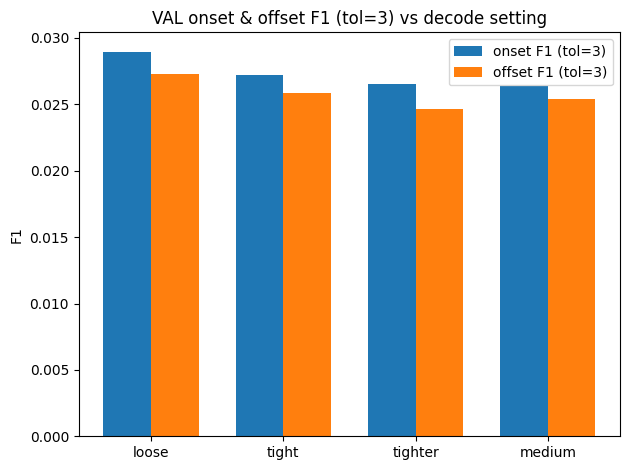

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_val_onset_offset_f1_sweep.png
Best decode: loose {'max_len': 900, 'min_len': 120, 'eos_bias_base': 0.1, 'eos_bias_slope': 0.01, 'hard_force_eos_at': 880, 'max_notes_per_frame': 8, 'max_active_notes': 12, 'note_penalty': 0.0}

FINAL VAL onset/offset: {'onset_P': 0.029608968513649647, 'onset_R': 0.02837171052631433, 'onset_F1': 0.02897713850757162, 'onset_tp': 552, 'onset_fp': 18091, 'onset_fn': 18904, 'offset_P': 0.02798899854392342, 'offset_R': 0.026668722059502253, 'offset_F1': 0.027312914430059277, 'offset_tp': 519, 'offset_fp': 18024, 'offset_fn': 18942}
FINAL TEST onset/offset: {'onset_P': 0.026347305389220428, 'onset_R': 0.023065977682916832, 'onset_F1': 0.024597691969811434, 'onset_tp': 616, 'onset_fp': 22764, 'onset_fn': 26090, 'offset_P': 0.024093275394741466, 'offset_R': 0.020931449502877293, 'offset_F1': 0.02240134408064439, 'offset_tp': 560, 'offset_fp': 22683, 'offset_fn': 26194}
Saved: /home/jovyan/

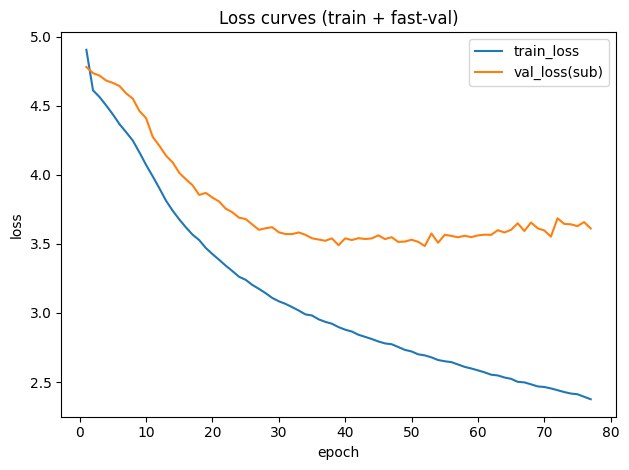

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_curve_loss.png


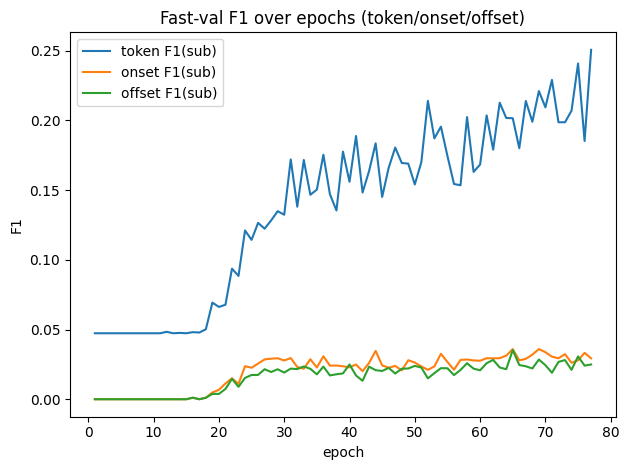

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_curve_f1s.png


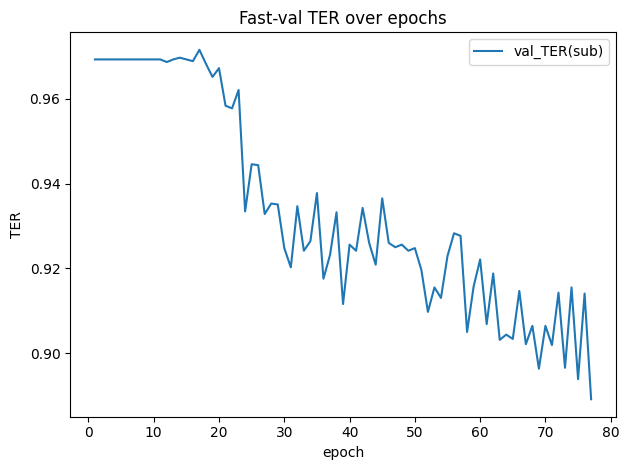

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_curve_ter.png


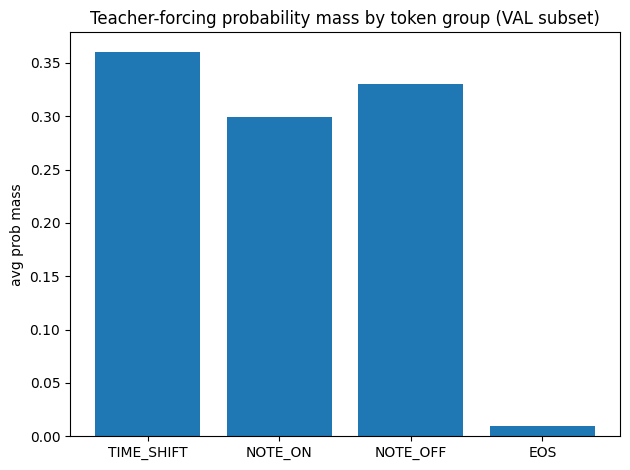

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_tf_mass.png


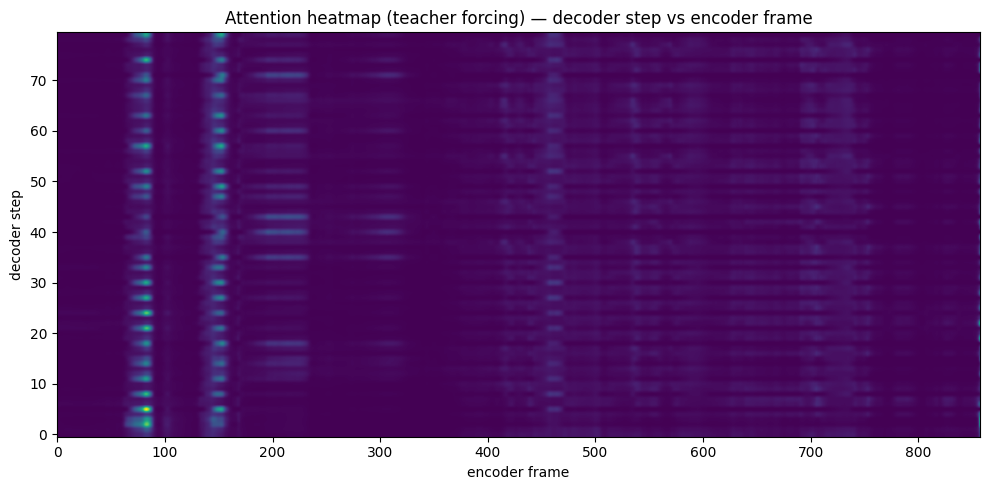

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_attention_heatmap.png


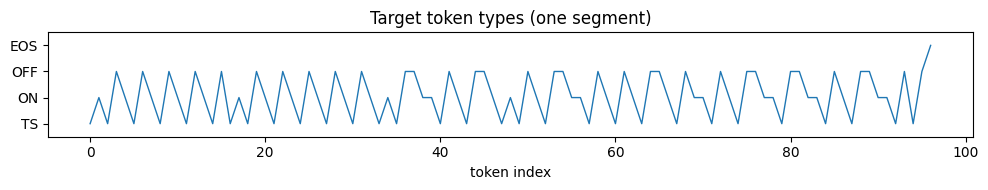

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_tok_types_target.png


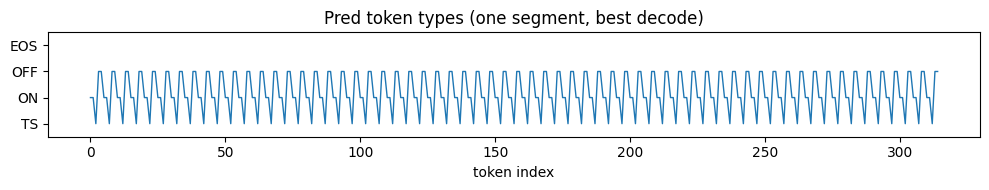

Saved: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_tok_types_pred.png

ZIP bundle: /home/jovyan/shared/musicnet_event_notebook/figures/20260118_173845_seq2seq_results.zip
Download via Jupyter file browser from: /home/jovyan/shared/musicnet_event_notebook/figures
Created files:
 - 20260118_173845_attention_heatmap.png
 - 20260118_173845_curve_f1s.png
 - 20260118_173845_curve_loss.png
 - 20260118_173845_curve_ter.png
 - 20260118_173845_final_onset_offset_metrics.json
 - 20260118_173845_seq2seq_results.zip
 - 20260118_173845_tf_mass.png
 - 20260118_173845_tok_types_pred.png
 - 20260118_173845_tok_types_target.png
 - 20260118_173845_val_onset_offset_f1_sweep.png
 - 20260118_173845_val_sweep_onset_offset_tol3.csv


In [24]:
# ============================================================
# BLOCK 10b (FULL EVAL + ALL VISUALS) — compatible with Block 10 above
# - Loads best checkpoint from best_s2s_path
# - VAL decode sweep (tol=3) using FULL decode (s2s_decode_greedy_full below)
# - Computes onset & offset F1 tolerant on VAL+TEST
# - Saves all result graphics + ZIP
#
# IMPORTANT: This block defines its own FULL decode function and does not
# depend on any old s2s_decode_greedy in your notebook.
# ============================================================

import os, json, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

FIG_DIR = Path(FIG_DIR); FIG_DIR.mkdir(parents=True, exist_ok=True)
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
print("RUN_TAG:", RUN_TAG)
print("FIG_DIR:", FIG_DIR)

def save_plot(path):
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.show()
    print("Saved:", path)

# -----------------------------
# Load best
# -----------------------------
s2s_model.load_state_dict(torch.load(best_s2s_path, map_location=DEVICE))
s2s_model.to(DEVICE).eval()
print("Loaded checkpoint:", best_s2s_path)

# -----------------------------
# FULL constrained-ish greedy decode (stable, no unpack errors)
# (uses attention that returns (ctx, attn))
# -----------------------------
@torch.no_grad()
def s2s_decode_greedy_full(model, X, x_lens,
                           max_len=900, min_len=120,
                           eos_bias_base=0.1, eos_bias_slope=0.01, hard_force_eos_at=880,
                           max_notes_per_frame=8, max_active_notes=12, note_penalty=0.0):
    """
    Full decode for evaluation. Simple constraints to avoid blow-ups.
    Returns list[list[int]] without EOS token appended.
    """
    model.eval()
    device = X.device
    B = X.size(0)
    enc, enc_mask = model.encode(X, x_lens)

    ys = torch.full((B, 1), SOS_ID, dtype=torch.long, device=device)
    ctx = torch.zeros((B, enc.size(-1)), device=device, dtype=enc.dtype)
    h = None
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    out = [[] for _ in range(B)]

    # pitch state
    active = torch.zeros((B, N_PITCH), dtype=torch.bool, device=device)
    notes_this_frame = torch.zeros(B, dtype=torch.long, device=device)

    for step in range(max_len):
        emb = model.emb(ys[:, -1])
        x_t = torch.cat([emb, ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, attn = model.attn(h_t, enc, enc_mask)  # ALWAYS 2 outputs now

        logits = model.out(torch.cat([h_t, ctx], dim=-1))

        logits[:, PAD_ID] = -1e9
        logits[:, SOS_ID] = -1e9
        logits[:, CTC_BLANK_ID] = -1e9

        # optional note penalty per frame
        if note_penalty != 0.0:
            logits[:, NOTE_ON_BASE:EVENT_VOCAB] -= notes_this_frame.float().unsqueeze(1) * note_penalty

        # block invalid on/off based on active state
        for p in range(N_PITCH):
            on_id = NOTE_ON_BASE + p
            off_id = NOTE_OFF_BASE + p
            logits[:, off_id] = torch.where(active[:, p], logits[:, off_id], torch.full_like(logits[:, off_id], -1e9))
            logits[:, on_id]  = torch.where(~active[:, p], logits[:, on_id],  torch.full_like(logits[:, on_id],  -1e9))

        # polyphony cap: block NOTE_ON if too many active
        too_poly = active.sum(dim=1) >= max_active_notes
        if too_poly.any():
            logits[too_poly, NOTE_ON_BASE:NOTE_OFF_BASE] = -1e9

        # cap note events per frame (after enough note events, discourage more)
        force_ts = notes_this_frame >= max_notes_per_frame
        if force_ts.any():
            logits[force_ts, NOTE_ON_BASE:EVENT_VOCAB] = -1e9  # forces TS or EOS if allowed

        # EOS control
        if step < min_len:
            logits[:, EOS_ID] = -1e9
        else:
            logits[:, EOS_ID] += (eos_bias_base + eos_bias_slope * (step - min_len))

        if step >= hard_force_eos_at:
            logits[:, EOS_ID] = 1e4

        nxt = logits.argmax(dim=-1)
        ys = torch.cat([ys, nxt.unsqueeze(1)], dim=1)

        for i in range(B):
            if finished[i]:
                continue
            t = int(nxt[i].item())
            if t == EOS_ID:
                finished[i] = True
                continue
            out[i].append(t)

            # update state
            if TIME_SHIFT_BASE <= t < NOTE_ON_BASE:
                notes_this_frame[i] = 0
            elif NOTE_ON_BASE <= t < NOTE_OFF_BASE:
                p = t - NOTE_ON_BASE
                active[i, p] = True
                notes_this_frame[i] += 1
            elif NOTE_OFF_BASE <= t < EVENT_VOCAB:
                p = t - NOTE_OFF_BASE
                active[i, p] = False
                notes_this_frame[i] += 1

        if bool(finished.all()):
            break

    return out

# -----------------------------
# Token -> onset/offset sets + tolerant match (reused)
# -----------------------------
def tokens_to_onsets_offsets(tokens):
    t = 0
    on = set()
    off = set()
    for tok in tokens:
        if tok == PAD_ID or tok == EOS_ID:
            continue
        if TIME_SHIFT_BASE <= tok < NOTE_ON_BASE:
            t += (tok - TIME_SHIFT_BASE) + 1
        elif NOTE_ON_BASE <= tok < NOTE_OFF_BASE:
            on.add((t, tok - NOTE_ON_BASE))
        elif NOTE_OFF_BASE <= tok < EVENT_VOCAB:
            off.add((t, tok - NOTE_OFF_BASE))
    return on, off

def tolerant_match(pred_set, gt_set, tol=3):
    gt_by_pitch = {}
    for f,p in gt_set:
        gt_by_pitch.setdefault(p, []).append(f)
    for p in gt_by_pitch:
        gt_by_pitch[p].sort()
    tp=0
    used=set()
    for f,p in pred_set:
        if p not in gt_by_pitch:
            continue
        for g in gt_by_pitch[p]:
            if (g,p) in used:
                continue
            if abs(g-f) <= tol:
                tp += 1
                used.add((g,p))
                break
    fp=len(pred_set)-tp
    fn=len(gt_set)-tp
    return tp,fp,fn

def prf(tp,fp,fn):
    P=tp/(tp+fp+1e-9)
    R=tp/(tp+fn+1e-9)
    F1=2*tp/(2*tp+fp+fn+1e-9)
    return P,R,F1

@torch.no_grad()
def eval_onset_offset_f1_full(model, loader, decode_kwargs, tol=3):
    model.eval()
    TP_on=FP_on=FN_on=0
    TP_off=FP_off=FN_off=0

    for batch in loader:
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"]
        yl = batch["y_lens"]

        preds = s2s_decode_greedy_full(model, X, xl, **decode_kwargs)

        for i in range(len(preds)):
            gt_tokens = y[i,:int(yl[i])].tolist()
            gt_on, gt_off = tokens_to_onsets_offsets(gt_tokens)
            pr_on, pr_off = tokens_to_onsets_offsets(preds[i])

            tp,fp,fn = tolerant_match(pr_on, gt_on, tol=tol)
            TP_on += tp; FP_on += fp; FN_on += fn

            tp,fp,fn = tolerant_match(pr_off, gt_off, tol=tol)
            TP_off += tp; FP_off += fp; FN_off += fn

    Pon,Ron,Fon = prf(TP_on,FP_on,FN_on)
    Poff,Roff,Foff = prf(TP_off,FP_off,FN_off)

    return {
        "onset_P": Pon, "onset_R": Ron, "onset_F1": Fon, "onset_tp": TP_on, "onset_fp": FP_on, "onset_fn": FN_on,
        "offset_P": Poff, "offset_R": Roff, "offset_F1": Foff, "offset_tp": TP_off, "offset_fp": FP_off, "offset_fn": FN_off,
    }

# -----------------------------
# VAL decode sweep (your known best candidate set)
# -----------------------------
base = dict(max_len=900, min_len=120, eos_bias_base=0.1, eos_bias_slope=0.01, hard_force_eos_at=880)
cands = [
    dict(setting="loose",   **base, max_notes_per_frame=8, max_active_notes=12, note_penalty=0.00),
    dict(setting="medium",  **base, max_notes_per_frame=6, max_active_notes=8,  note_penalty=0.15),
    dict(setting="tight",   **base, max_notes_per_frame=5, max_active_notes=6,  note_penalty=0.20),
    dict(setting="tighter", **base, max_notes_per_frame=4, max_active_notes=6,  note_penalty=0.25),
]

rows=[]
for cfg in cands:
    dk = {k:v for k,v in cfg.items() if k!="setting"}
    m = eval_onset_offset_f1_full(s2s_model, val_loader, dk, tol=3)
    rows.append({"setting": cfg["setting"], **m, **dk})
    print("VAL", cfg["setting"], "=> onsetF1", round(m["onset_F1"],4), "offsetF1", round(m["offset_F1"],4))

sweep_df = pd.DataFrame(rows).sort_values("onset_F1", ascending=False)
sweep_csv = FIG_DIR / f"{RUN_TAG}_val_sweep_onset_offset_tol3.csv"
sweep_df.to_csv(sweep_csv, index=False)
print("Saved:", sweep_csv)

plt.figure()
x = np.arange(len(sweep_df))
plt.bar(x-0.18, sweep_df["onset_F1"], width=0.36, label="onset F1 (tol=3)")
plt.bar(x+0.18, sweep_df["offset_F1"], width=0.36, label="offset F1 (tol=3)")
plt.xticks(x, sweep_df["setting"])
plt.ylabel("F1")
plt.title("VAL onset & offset F1 (tol=3) vs decode setting")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_val_onset_offset_f1_sweep.png")

best_row = sweep_df.iloc[0].to_dict()
best_decode = {k: best_row[k] for k in ["max_len","min_len","eos_bias_base","eos_bias_slope","hard_force_eos_at","max_notes_per_frame","max_active_notes","note_penalty"]}
print("Best decode:", best_row["setting"], best_decode)

# Final VAL/TEST onset+offset
val_metrics = eval_onset_offset_f1_full(s2s_model, val_loader, best_decode, tol=3)
test_metrics = eval_onset_offset_f1_full(s2s_model, test_loader, best_decode, tol=3)
print("\nFINAL VAL onset/offset:", val_metrics)
print("FINAL TEST onset/offset:", test_metrics)

metrics_json = FIG_DIR / f"{RUN_TAG}_final_onset_offset_metrics.json"
with open(metrics_json, "w") as f:
    json.dump({"best_decode": best_decode, "val": val_metrics, "test": test_metrics}, f, indent=2)
print("Saved:", metrics_json)

# -----------------------------
# Training curves from history_csv
# -----------------------------
hist = pd.read_csv(history_csv)
ep = hist["epoch"].values

plt.figure()
plt.plot(ep, hist["train_loss"], label="train_loss")
plt.plot(ep, hist["val_loss_sub"], label="val_loss(sub)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss curves (train + fast-val)")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_curve_loss.png")

plt.figure()
plt.plot(ep, hist["val_F1_sub"], label="token F1(sub)")
plt.plot(ep, hist["val_onset_F1_sub"], label="onset F1(sub)")
plt.plot(ep, hist["val_offset_F1_sub"], label="offset F1(sub)")
plt.xlabel("epoch"); plt.ylabel("F1")
plt.title("Fast-val F1 over epochs (token/onset/offset)")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_curve_f1s.png")

plt.figure()
plt.plot(ep, hist["val_TER_sub"], label="val_TER(sub)")
plt.xlabel("epoch"); plt.ylabel("TER")
plt.title("Fast-val TER over epochs")
plt.legend()
save_plot(FIG_DIR / f"{RUN_TAG}_curve_ter.png")

# -----------------------------
# TF token-group mass plot
# -----------------------------
@torch.no_grad()
def tf_mass_by_group(model, loader, num_batches=5):
    model.eval()
    mass_ts=mass_on=mass_off=mass_eos=0.0
    count=0
    ce = nn.CrossEntropyLoss(ignore_index=PAD_ID, weight=CLASS_W)
    for bi, batch in enumerate(loader):
        if bi>=num_batches: break
        X  = batch["X"].to(DEVICE, non_blocking=True)
        xl = batch["x_lens"].to(DEVICE, non_blocking=True)
        y  = batch["y"].to(DEVICE, non_blocking=True)
        yl = batch["y_lens"].to(DEVICE, non_blocking=True)
        y_in, y_out = make_s2s_io_event(y, yl)
        logits = s2s_model.forward_teacher_forcing(X, xl, y_in)
        probs = torch.softmax(logits.float(), dim=-1)
        mask = (y_out != PAD_ID)
        m = mask.sum().item()
        if m==0: continue
        ts = probs[:,:,TIME_SHIFT_BASE:NOTE_ON_BASE].sum(dim=-1)
        on = probs[:,:,NOTE_ON_BASE:NOTE_OFF_BASE].sum(dim=-1)
        off= probs[:,:,NOTE_OFF_BASE:EVENT_VOCAB].sum(dim=-1)
        eos= probs[:,:,EOS_ID]
        mass_ts += float(ts[mask].sum().item()/m)
        mass_on += float(on[mask].sum().item()/m)
        mass_off+= float(off[mask].sum().item()/m)
        mass_eos+= float(eos[mask].sum().item()/m)
        count += 1
    return {"TIME_SHIFT": mass_ts/max(1,count),
            "NOTE_ON": mass_on/max(1,count),
            "NOTE_OFF": mass_off/max(1,count),
            "EOS": mass_eos/max(1,count)}

tfm = tf_mass_by_group(s2s_model, val_loader, num_batches=5)
plt.figure()
plt.bar(list(tfm.keys()), list(tfm.values()))
plt.title("Teacher-forcing probability mass by token group (VAL subset)")
plt.ylabel("avg prob mass")
save_plot(FIG_DIR / f"{RUN_TAG}_tf_mass.png")

# -----------------------------
# Attention heatmap (fast) using returned attn weights
# -----------------------------
@torch.no_grad()
def attention_heatmap_example(model, loader, max_steps=80):
    batch = next(iter(loader))
    X  = batch["X"][:1].to(DEVICE)
    xl = batch["x_lens"][:1].to(DEVICE)
    y  = batch["y"][:1].to(DEVICE)
    yl = batch["y_lens"][:1].to(DEVICE)
    y_in, y_out = make_s2s_io_event(y, yl)

    enc, enc_mask = model.encode(X, xl)
    ctx = torch.zeros((1, enc.size(-1)), device=DEVICE, dtype=enc.dtype)
    h = None
    emb_all = model.emb(y_in)  # (1,L,dec)

    A = []
    L = min(y_in.size(1), max_steps)
    for t in range(L):
        x_t = torch.cat([emb_all[:, t, :], ctx], dim=-1).unsqueeze(1)
        o, h = model.lstm(x_t, h)
        h_t = o.squeeze(1)
        ctx, attn = model.attn(h_t, enc, enc_mask)  # (1,D), (1,T)
        A.append(attn.squeeze(0).detach().cpu().numpy())
    return np.stack(A, axis=0)

A = attention_heatmap_example(s2s_model, val_loader, max_steps=80)
plt.figure(figsize=(10,5))
plt.imshow(A, aspect="auto", origin="lower")
plt.title("Attention heatmap (teacher forcing) — decoder step vs encoder frame")
plt.xlabel("encoder frame"); plt.ylabel("decoder step")
save_plot(FIG_DIR / f"{RUN_TAG}_attention_heatmap.png")

# -----------------------------
# Token-type timelines (target vs predicted)
# -----------------------------
def tok_type(t):
    if TIME_SHIFT_BASE <= t < NOTE_ON_BASE: return 0
    if NOTE_ON_BASE <= t < NOTE_OFF_BASE: return 1
    if NOTE_OFF_BASE <= t < EVENT_VOCAB: return 2
    if t == EOS_ID: return 3
    return 4

def plot_token_types(seq, title, path, max_tokens=400):
    types = [tok_type(t) for t in seq[:max_tokens]]
    plt.figure(figsize=(10,2))
    plt.plot(types, linewidth=1)
    plt.yticks([0,1,2,3], ["TS","ON","OFF","EOS"])
    plt.ylim(-0.5,3.5)
    plt.title(title); plt.xlabel("token index")
    save_plot(path)

batch = next(iter(val_loader))
tgt = batch["y"][0, :batch["y_lens"][0].item()].cpu().numpy().tolist()
pred = s2s_decode_greedy_full(s2s_model, batch["X"][:1].to(DEVICE), batch["x_lens"][:1].to(DEVICE), **best_decode)[0]
plot_token_types(tgt, "Target token types (one segment)", FIG_DIR / f"{RUN_TAG}_tok_types_target.png")
plot_token_types(pred, "Pred token types (one segment, best decode)", FIG_DIR / f"{RUN_TAG}_tok_types_pred.png")

# -----------------------------
# ZIP bundle
# -----------------------------
zip_path = FIG_DIR / f"{RUN_TAG}_seq2seq_results.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in FIG_DIR.glob(f"{RUN_TAG}_*"):
        zf.write(p, arcname=p.name)
    zf.write(Path(history_csv), arcname=Path(history_csv).name)
    zf.write(Path(best_s2s_path), arcname=Path(best_s2s_path).name)

print("\nZIP bundle:", zip_path)
print("Download via Jupyter file browser from:", FIG_DIR)
print("Created files:")
for p in sorted(FIG_DIR.glob(f"{RUN_TAG}_*")):
    print(" -", p.name)
